In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# gereksiz uyarıları kapatalım
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
from distutils.dir_util import copy_tree, remove_tree
default_dir = "Alzheimer_s Dataset/"
root_dir = "./"
test_dir = default_dir + "test/"
train_dir = default_dir + "train/"

print("Working Directory Contents:", os.listdir(train_dir))
#work_dir = root_dir + "dataset/"
"""
if os.path.exists(work_dir):
    remove_tree(work_dir)
"""   

#os.mkdir(train_dir)
#copy_tree(train_dir, work_dir)
#copy_tree(test_dir, work_dir)
#çalışma dizininin içeriği listelenir.

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [5]:
CLASSES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

IMG_SIZE = [176, 208]

DIM = (IMG_SIZE[0], IMG_SIZE[1])

"""
Bu boyutlar, görüntü işleme uygulamalarında kullanılacak
olan görüntülerin boyutunu ve sınıflandırma sınıflarını tanımlamak için kullanılır.
"""

'\nBu boyutlar, görüntü işleme uygulamalarında kullanılacak\nolan görüntülerin boyutunu ve sınıflandırma sınıflarını tanımlamak için kullanılır.\n'

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Keras'ın görüntü veri işleme işlevleri
"""
Bu kod parçası, TensorFlow'un Keras API'sini kullanarak görüntü verilerini önceden işlemek için kullanılan
bir ImageDataGenerator nesnesini tanımlar.Bu nesne, veri artırma ve normalizasyon işlemlerini 
gerçekleştirmek için kullanılabilir.
"""

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [16]:
from tensorflow.keras.preprocessing import image, image_dataset_from_directory #veri ön işleme işlevlerini içe aktarıyoruz.
"""
Bu kod, belirtilen dizinden görüntülerin yüklenmesi,belirtilen toplu boyutlarla veri kümesinin oluşturulması
işlemini gerçekleştirir.Oluşturulan train_dataset veri kümesi, ardından bir derin öğrenme modelinin eğitiminde kullanacağız.

"""

train_dataset = image_generator.flow_from_directory(batch_size=6000,
                                                    directory=train_dir,
                                                    target_size=(176, 208),
                                                    shuffle= True)

Found 5121 images belonging to 4 classes.


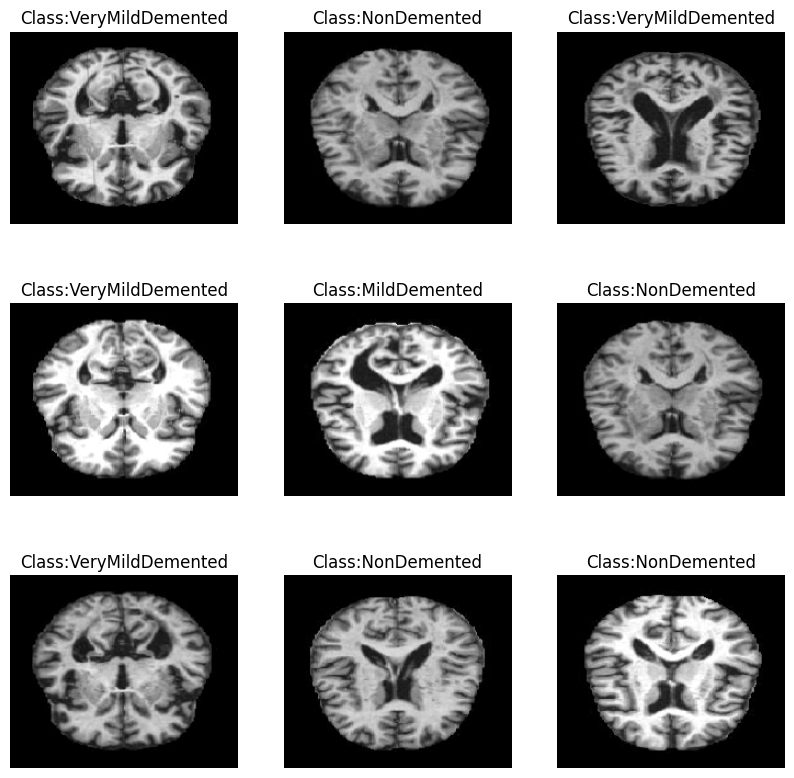

In [9]:
#veri kümesindeki görüntüleri görselleştirmek için kullanılır. Özellikle eğitim verilerini göstermek için tasarlanmıştır.
from random import randint
def show_images(generator,y_pred=None):
  
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a lot of images
    x,y = generator.next()
    
    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0,50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(27):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

<BarContainer object of 4 artists>

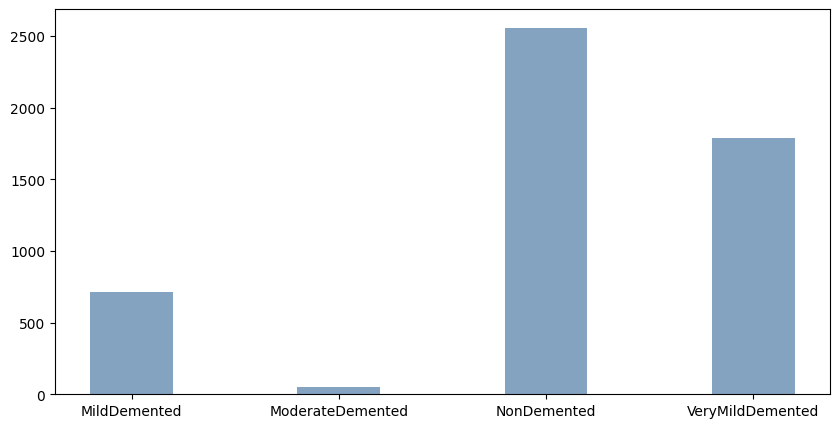

In [10]:
"""
Bu kod, veri kümesindeki her sınıfın örnek sayısını görsel olarak gösteren bir çubuk grafik (bar plot) oluşturur. 
Bu grafik, veri kümesinin sınıf dağılımını incelemek ve dengesizlikleri tespit etmek için kullanılabilir.
"""
data = {'MildDemented':      0, 
        'ModerateDemented': 0, 
        'NonDemented':     0,
        'VeryMildDemented': 0}
# visualizing dataset
for cls in os.listdir(train_dir):
    for img in os.listdir(train_dir + '/' + cls):
        data[cls] = data[cls] + 1
        
keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

In [30]:
train_data, train_labels = train_dataset.next()

In [31]:
print(train_data.shape, train_labels.shape)

(5121, 176, 208, 3) (5121, 4)


In [32]:
"""
Bu kod, eğitim verilerinizi, test verilerini ve doğrulama (validation) verilerini oluşturmak için train_test_split 
işlevini kullanır. Bu, genellikle bir makine öğrenme modelini eğitirken veri setini bölmenin yaygın bir yoludur.

"""


from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.25, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)


In [33]:
print(train_data.shape, train_labels.shape)

(3072, 176, 208, 3) (3072, 4)


In [34]:
print(test_data.shape, test_labels.shape)

(1281, 176, 208, 3) (1281, 4)


In [35]:
print(val_data.shape, val_labels.shape)

(768, 176, 208, 3) (768, 4)


In [36]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout #derin öğrenme modelinin inşası için kullanılır.
from tensorflow.keras.models import Model #Keras'ın model oluşturma işlevlerini içe aktarıyoruz.
from tensorflow.keras.utils import plot_model #modelin yapısını görselleştirmek için kullanılır.
from tensorflow.keras.preprocessing import image, image_dataset_from_directory #veri ön işleme işlevlerini içe aktarıyoruz.
from imblearn.over_sampling import SMOTE
#dengesiz sınıf dağılımını ele almak için SMOTE (Sentetik Azaltma ve Artırma Tekniği) adlı bir örnekleme tekniklerini içe aktarıyoruz.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Keras'ın görüntü veri işleme işlevleri
from tensorflow.keras.callbacks import EarlyStopping #eğitim sırasında geri arama işlevlerini içe aktarıyoruz.
from tensorflow.keras.models import Sequential #Keras modellerini oluşturmak için kullanılan işlevleri içe aktarıyoruz.
from random import randint

model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(176, 208, 3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(),

    keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    keras.layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.SeparableConv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),

    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.7),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(4, activation='softmax')
])

In [37]:
"""
Sonuç olarak, bu kod, verileri kullanarak belirtilen sayıda epoch boyunca modelin eğitilmesini başlatır
ve eğitim sırasında doğrulama veri seti üzerindeki performansı izler. Eğitim sonunda, modelin belirtilen 
verilere ne kadar iyi uydurduğunu ve doğrulama veri seti üzerinde ne kadar iyi performans gösterdiğini değerlendirmek
için bir geçmiş (history) nesnesi döner. Bu geçmiş nesnesi, eğitim ve doğrulama süreçlerinin metriklerini
(örneğin, kayıp ve doğruluk) içerir ve sonuçları incelemek için kullanılabilir.
"""
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [38]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=80)


Epoch 1/80
96/96 [==============================] - 68s 624ms/step - loss: 1.7921 - acc: 0.3285 - auc: 0.5775 - val_loss: 1.2121 - val_acc: 0.4766 - val_auc: 0.6984
Epoch 2/80
96/96 [==============================] - 57s 590ms/step - loss: 1.3698 - acc: 0.4215 - auc: 0.6902 - val_loss: 1.1213 - val_acc: 0.4766 - val_auc: 0.7665
Epoch 3/80
96/96 [==============================] - 58s 600ms/step - loss: 1.1871 - acc: 0.4824 - auc: 0.7551 - val_loss: 1.1238 - val_acc: 0.4766 - val_auc: 0.7778
Epoch 4/80
96/96 [==============================] - 58s 606ms/step - loss: 1.0948 - acc: 0.5013 - auc: 0.7841 - val_loss: 1.1185 - val_acc: 0.4766 - val_auc: 0.7797
Epoch 5/80
96/96 [==============================] - 60s 630ms/step - loss: 1.0288 - acc: 0.5127 - auc: 0.8053 - val_loss: 1.0678 - val_acc: 0.4766 - val_auc: 0.8052
Epoch 6/80
96/96 [==============================] - 62s 647ms/step - loss: 0.9831 - acc: 0.5309 - auc: 0.8193 - val_loss: 1.0717 - val_acc: 0.4766 - val_auc: 0.8107
Epoch 7/80

96/96 [==============================] - 60s 624ms/step - loss: 0.1826 - acc: 0.9320 - auc: 0.9933 - val_loss: 0.8531 - val_acc: 0.7682 - val_auc: 0.9246
Epoch 51/80
96/96 [==============================] - 61s 640ms/step - loss: 0.1785 - acc: 0.9336 - auc: 0.9933 - val_loss: 0.7799 - val_acc: 0.7656 - val_auc: 0.9279
Epoch 52/80
96/96 [==============================] - 63s 661ms/step - loss: 0.1820 - acc: 0.9365 - auc: 0.9931 - val_loss: 1.6574 - val_acc: 0.6094 - val_auc: 0.8336
Epoch 53/80
96/96 [==============================] - 64s 664ms/step - loss: 0.1689 - acc: 0.9401 - auc: 0.9940 - val_loss: 1.6652 - val_acc: 0.6107 - val_auc: 0.8355
Epoch 54/80
96/96 [==============================] - 63s 657ms/step - loss: 0.1614 - acc: 0.9434 - auc: 0.9944 - val_loss: 2.1948 - val_acc: 0.5221 - val_auc: 0.7747
Epoch 55/80
96/96 [==============================] - 63s 661ms/step - loss: 0.1785 - acc: 0.9316 - auc: 0.9932 - val_loss: 0.6477 - val_acc: 0.8073 - val_auc: 0.9481
Epoch 56/80
96/9

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 174, 206, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 87, 103, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 102, 32)       2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 51, 32)        0         
 g2D)                                                            
                                                                 
 separable_conv2d (Separabl  (None, 43, 51, 64)        2400      
 eConv2D)                                                        
                                                        

In [40]:
loss, accuracy,auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)


41/41 [==============================] - 7s 154ms/step - loss: 0.5914 - acc: 0.8407 - auc: 0.9538
Loss:  0.5913999676704407
Accuracy:  0.8407494425773621


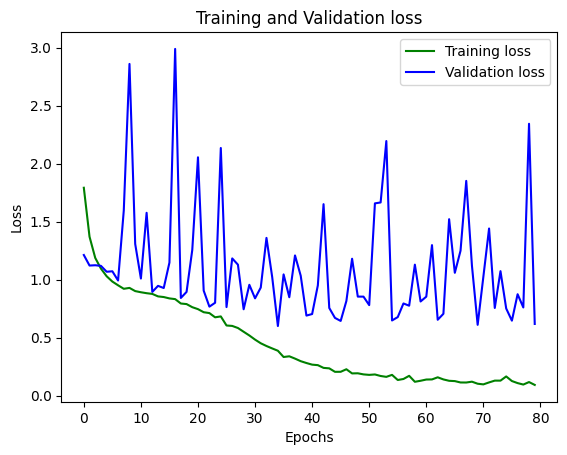

In [41]:
loss_train = history.history['loss'][:80]  # Take the first 50 elements of loss_train
loss_val = history.history['val_loss'][:80]  # Take the first 50 elements of loss_val
epochs = range(0, 80)

plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


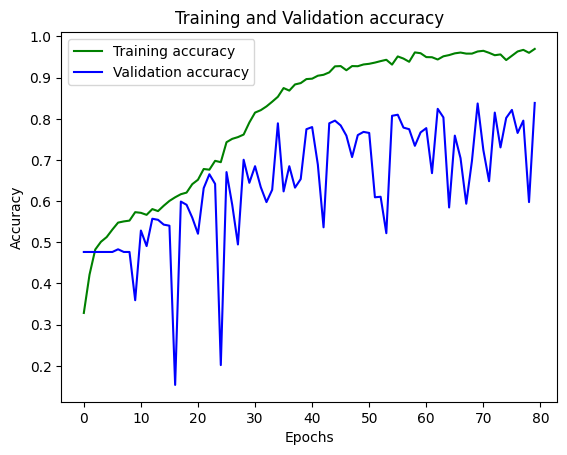

In [42]:
acc_train = history.history['acc'][:80]  # Take the first 50 elements of acc_train
acc_val = history.history['val_acc'][:80]  # Take the first 50 elements of acc_val
epochs = range(0, 80)

plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [43]:
# Modeli TensorFlow 2.x ile kaydedin
model.save('model.keras')


In [44]:
# Modeli TensorFlow 2.x ile kaydedin
model.save('model.h5')  # Modeli kaydet

# Model ağırlıklarını kaydet
model.save_weights('model_weights.h5')  # Ağırlıkları kaydet


In [46]:
import pickle
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)